# NDVI Project

### Introduction
Looking at changes in NDVI in a chosen location.

In [28]:
### vector data
import geopandas as gpd
import pandas as pd

### raster data
import rioxarray as rxr
import xarray as xr

### maps and plots
import holoviews as hv
import hvplot.pandas
import hvplot.xarray

### open street map
from osmnx import features as osm
import osmnx as ox

### file structure
import os
import pathlib

### earthpy
import earthpy
import earthpy.api.appeears as eaapp

### plotting
import matplotlib.pyplot as plt # Basic plotting

In [2]:
### set up project and folder for data
project = earthpy.Project("Gila River Vegetation", dirname = 'ndvi_project')

In [3]:
### search for PRNS
rmnp_gdf = ox.geocode_to_gdf(
    'Rocky Mountain National Park')

### check it out
rmnp_gdf

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"MULTIPOLYGON (((-105.53362 40.29996, -105.5338...",-105.913714,40.15777,-105.493583,40.553787,416089268,relation,390960,40.355392,-105.717696,boundary,protected_area,25,0.520509,protected_area,Rocky Mountain National Park,"Rocky Mountain National Park, Larimer County, ..."


<Axes: >

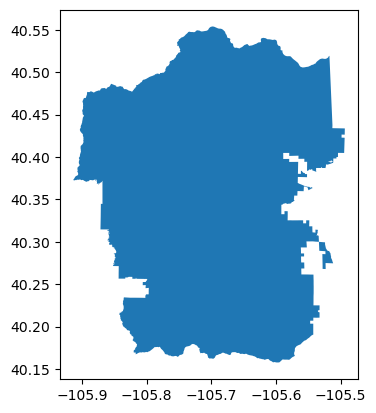

In [5]:
### make a quick plot
rmnp_gdf.plot()

In [6]:
### initialize AppeearsDownloader for MODIS NDVI data
### set parameters
ndvi_downloader = eaapp.AppeearsDownloader(

    ### give your download a name
    download_key = "rmnp_ndvi",

    ### tell it to put the data in your project that you already defined
    project = project,

    ### specify the MODIS product you want
    product = 'MOD13Q1.061',
    layer = '_250m_16_days_NDVI',

    ### choose a start date and end data
    start_date = "01-01",
    end_date = "01-30",

    ### recurring means you want those dates over multiple years
    recurring = True,

    ### specify the range of years you want
    year_range = [2000, 2020],

    ### specify the polygon you want to get NDVI data for
    polygon = rmnp_gdf
)

In [7]:
### download the prepared download -- this can take a while!
ndvi_downloader.download_files(cache=True)

No stored credentials found for urs.earthdata.nasa.gov. Please log in.


/opt/conda/lib/python3.11/site-packages/earthpy/api/auth.py:192: UserWarning: Setting credentials not supported for 'netrc' backend.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/earthpy/api/auth.py:196: UserWarning: Failed to store credentials with 'keyring': No recommended backend was available. Install a recommended 3rd party backend package; or, install the keyrings.alt package if you want to use the non-recommended backends. See https://pypi.org/project/keyring for details.
  warnings.warn(


Credentials stored using 'env' backend.


In [8]:
### get a sorted list of NDVI file paths
ndvi_paths = sorted(list(project.project_dir.rglob('*NDVI*.tif')))

ndvi_paths

[PosixPath('/workspaces/data/ndvi_project/rmnp_ndvi/MOD13Q1.061_1999351_to_2020030/MOD13Q1.061__250m_16_days_NDVI_doy2000353000000_aid0001.tif'),
 PosixPath('/workspaces/data/ndvi_project/rmnp_ndvi/MOD13Q1.061_1999351_to_2020030/MOD13Q1.061__250m_16_days_NDVI_doy2001001000000_aid0001.tif'),
 PosixPath('/workspaces/data/ndvi_project/rmnp_ndvi/MOD13Q1.061_1999351_to_2020030/MOD13Q1.061__250m_16_days_NDVI_doy2001017000000_aid0001.tif'),
 PosixPath('/workspaces/data/ndvi_project/rmnp_ndvi/MOD13Q1.061_1999351_to_2020030/MOD13Q1.061__250m_16_days_NDVI_doy2001353000000_aid0001.tif'),
 PosixPath('/workspaces/data/ndvi_project/rmnp_ndvi/MOD13Q1.061_1999351_to_2020030/MOD13Q1.061__250m_16_days_NDVI_doy2002001000000_aid0001.tif'),
 PosixPath('/workspaces/data/ndvi_project/rmnp_ndvi/MOD13Q1.061_1999351_to_2020030/MOD13Q1.061__250m_16_days_NDVI_doy2002017000000_aid0001.tif'),
 PosixPath('/workspaces/data/ndvi_project/rmnp_ndvi/MOD13Q1.061_1999351_to_2020030/MOD13Q1.061__250m_16_days_NDVI_doy2002353

In [ ]:
# Select and merge the subdivisions you want
rmnp_boundary_gdf = rmnp_gdf
# Plot the results with web tile images
rmnp_boundary_gdf.hvplot(
    geo=True, 
    tiles='EsriImagery',
    fill_color=None, 
    line_color='red',
    line_width=2,
    title='Rocky Mountain National Park Boundary',
    frame_width=500)


:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [22]:
# Extracting the string of date values from the file names 
# Including the .tif in character count
doy_start = -25 # Counting backwards to the first character of the date string
doy_end = -18 # Counting backwards to the last character of the date string

# Loop through each NDVI image
ndvi_das = []
for ndvi_path in ndvi_paths:
    # Get date from file name
    doy = ndvi_path.name[doy_start:doy_end] #Extract the date
    date = pd.to_datetime(doy, format='%Y%j') #Turn it into pandas date-time object

    # Open the NDVI dataset (da = data array)
    da = rxr.open_rasterio(ndvi_path, mask_and_scale=True).squeeze()

    # Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Prepare for concatenation
    ndvi_das.append(da)

len(ndvi_das) # Check the number of NDVI files in ndvi_das

60

In [23]:
# Combine NDVI images from all dates
# Gives us an "NDVI" column
ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])
ndvi_da

/tmp/ipykernel_14454/1138904771.py:3: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])
/tmp/ipykernel_14454/1138904771.py:3: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])


<xarray.Dataset> Size: 9MB
Dimensions:      (date: 60, y: 191, x: 203)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 2kB -105.9 -105.9 -105.9 ... -105.5 -105.5 -105.5
  * y            (y) float64 2kB 40.55 40.55 40.55 40.55 ... 40.16 40.16 40.16
    spatial_ref  int64 8B 0
  * date         (date) datetime64[ns] 480B 2000-12-18 2001-01-01 ... 2020-01-17
Data variables:
    NDVI         (date, y, x) float32 9MB 0.1285 0.1285 0.0432 ... 0.5178 0.5165

Text(0.5, 1.0, 'RMNP NDVI image 1 from 2000')

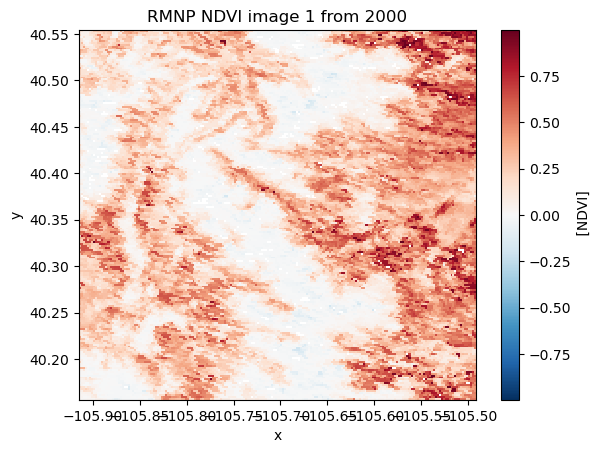

In [25]:
# Plot the 1st tif file from ndvi_paths
first_image = rxr.open_rasterio(ndvi_paths[0], mask_and_scale=True).squeeze().plot()
first_image.axes.set_title("RMNP NDVI image 1 from 2000")

Text(0.5, 1.0, 'NDVI - RMNP 2020')

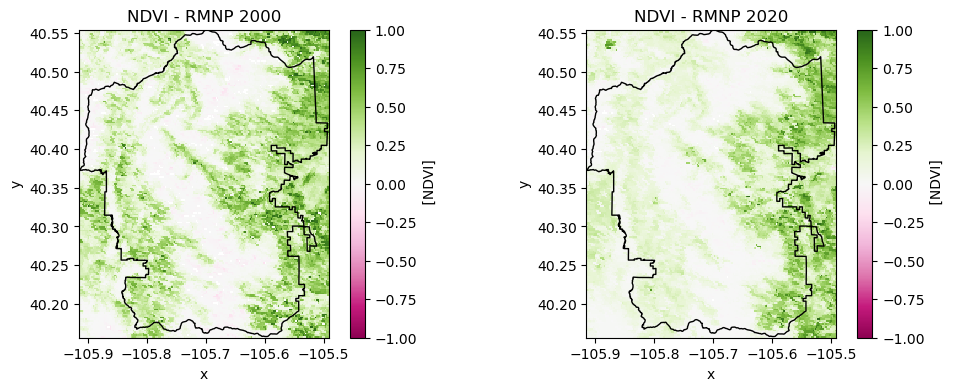

In [30]:
# Plot 1st and last NDVI images side-by-side for comparison
old_ndvi = rxr.open_rasterio(ndvi_paths[0], mask_and_scale=True).squeeze()
recent_ndvi = rxr.open_rasterio(ndvi_paths[-1], mask_and_scale=True).squeeze()

# Create side-by-side subplots
# This part was created thanks to the video demonstration
fig, axes = plt.subplots(1 , 2, figsize=[12, 4])

# Plot each in their own axes. PiYG is a value for the green/pink color scheme
old_ndvi.plot(ax=axes[0], cmap=plt.cm.PiYG, vmin=-1, vmax=1) 
rmnp_boundary_gdf.plot(ax=axes[0], edgecolor='black', facecolor='none', linewidth=1)
axes[0].set_title("NDVI - RMNP 2000")

# Ploting the recent ndvi image using axis 1
recent_ndvi.plot(ax=axes[1], cmap=plt.cm.PiYG, vmin=-1, vmax=1)
rmnp_boundary_gdf.plot(ax=axes[1], edgecolor='black', facecolor='none', linewidth=1)
axes[1].set_title("NDVI - RMNP 2020")

In [31]:
# Compute the difference in NDVI before and after the return of water rights in 2004
ndvi_diff = (
    ndvi_da
        .sel(date=slice('2010', '2020'))
        .mean('date')
        .NDVI
    - ndvi_da
        .sel(date=slice('2000','2010'))
        .mean('date')
        .NDVI
)
ndvi_diff
# Here we are subtracting the mean NDVI of 2001-2011 from the mean NDVI of 2012-2022. 

<xarray.DataArray 'NDVI' (y: 191, x: 203)> Size: 155kB
array([[-0.01947549,  0.00262228,  0.00445656, ...,  0.04209709,
         0.01532227,  0.01314032],
       [-0.00367611,  0.00388962,  0.00457167, ...,  0.00457579,
         0.04222375,  0.02197576],
       [-0.01369778, -0.00571763, -0.00571763, ..., -0.02464259,
        -0.01570261, -0.01570261],
       ...,
       [ 0.00936431,  0.01393387,  0.0147625 , ...,  0.00457525,
        -0.00447509, -0.01597708],
       [ 0.00933667,  0.01522956,  0.01683437, ..., -0.01547492,
        -0.00546366, -0.00546366],
       [ 0.00733317,  0.00933226,  0.00933226, ..., -0.01278794,
        -0.01278794, -0.01666373]], shape=(191, 203), dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 2kB -105.9 -105.9 -105.9 ... -105.5 -105.5 -105.5
  * y            (y) float64 2kB 40.55 40.55 40.55 40.55 ... 40.16 40.16 40.16
    spatial_ref  int64 8B 0

In [33]:
# Plot the difference
(
    ndvi_diff.hvplot(
        x='x', 
        y='y', 
        cmap='PiYG', 
        geo=True, 
        title="NDVI Changes in Rocky Mountain National Park \n2010-2020 vs. 2000-2010")
    * # Adding the boundary plot from earlier
    rmnp_boundary_gdf.hvplot(
        geo=True, 
        fill_color=None, 
        line_color='black',
        frame_width=500)
)

:Overlay
   .Image.I    :Image   [x,y]   (NDVI)
   .Polygons.I :Polygons   [Longitude,Latitude]

<Axes: >

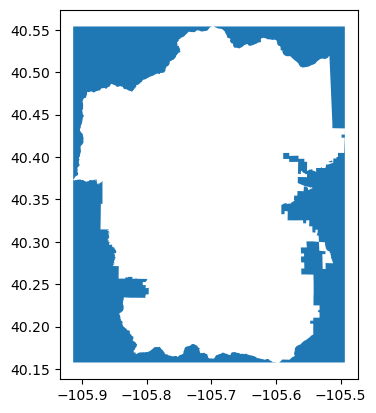

In [35]:
# Compute the area outside the Gila River Indian Community
outside_rmnp_gdf = (
    gpd.GeoDataFrame(geometry=rmnp_boundary_gdf.envelope)
    .overlay(rmnp_boundary_gdf, how='difference')
)

# Taking the 'difference' allows us to select the area outside the boundary

# Plot the outside Gila gdf
outside_rmnp_gdf.plot()

In [36]:
# Clip NDVI data to both inside and outside the boundary
ndvi_inside = ndvi_da.rio.clip(rmnp_boundary_gdf.geometry, from_disk=True)
print(ndvi_inside)

ndvi_outside = ndvi_da.rio.clip(outside_rmnp_gdf.geometry, from_disk=True)
print(ndvi_outside)

<xarray.Dataset> Size: 9MB
Dimensions:      (x: 201, y: 190, date: 60)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 2kB -105.9 -105.9 -105.9 ... -105.5 -105.5 -105.5
  * y            (y) float64 2kB 40.55 40.55 40.55 40.55 ... 40.16 40.16 40.16
  * date         (date) datetime64[ns] 480B 2000-12-18 2001-01-01 ... 2020-01-17
    spatial_ref  int64 8B 0
Data variables:
    NDVI         (date, y, x) float32 9MB nan nan nan nan ... nan nan nan nan
<xarray.Dataset> Size: 9MB
Dimensions:      (x: 202, y: 190, date: 60)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 2kB -105.9 -105.9 -105.9 ... -105.5 -105.5 -105.5
  * y            (y) float64 2kB 40.55 40.55 40.55 40.55 ... 40.16 40.16 40.16
  * date         (date) datetime64[ns] 480B 2000-12-18 2001-01-01 ... 2020-01-17
    spatial_ref  int64 8B 0
Data variables:
    NDVI         (date, y, x) float32 9MB 0.1285 0.1285 0.0432 ... 0.5169 0.5038


In [37]:
# Compute mean annual January NDVI
jan_ndvi_inside_df = (
    ndvi_inside
        .groupby(ndvi_inside.date.dt.year)
        .mean(...)
        .NDVI
        .to_dataframe()
)
print("Mean NDVI inside RMNP Boundary", jan_ndvi_inside_df.head())

jan_ndvi_outside_df = (
    ndvi_outside
        .groupby(ndvi_outside.date.dt.year)
        .mean(...)
        .NDVI
        .to_dataframe()
)
print("Mean NDVI outside RMNP Boundary", jan_ndvi_outside_df.head())
# Produces a NDVI Column that represents the average NDVI for each year

Mean NDVI inside RMNP Boundary       band  spatial_ref      NDVI
year                             
2000     1            0  0.202534
2001     1            0  0.262729
2002     1            0  0.245032
2003     1            0  0.242526
2004     1            0  0.239577
Mean NDVI outside RMNP Boundary       band  spatial_ref      NDVI
year                             
2000     1            0  0.276744
2001     1            0  0.334754
2002     1            0  0.314590
2003     1            0  0.325537
2004     1            0  0.306118


In [38]:
# Join inside and outside GRIC df and rename columns
jan_ndvi_df = (
    jan_ndvi_inside_df[['NDVI']]
    .join(jan_ndvi_outside_df[['NDVI']],
          lsuffix='_Inside_RMNP',
          rsuffix='_Outside_RMNP')
)
jan_ndvi_df

,NDVI_Inside_RMNP,NDVI_Outside_RMNP
year,,
2000,0.202534,0.276744
2001,0.262729,0.334754
2002,0.245032,0.314590
2003,0.242526,0.325537
2004,0.239577,0.306118
2005,0.224774,0.305300
2006,0.203688,0.262113
2007,0.171129,0.214271
2008,0.187286,0.243634


In [39]:
# Plot mean NDVI inside and outside RMNP boundary
jan_ndvi_df.hvplot(title='Mean January NDVI Inside and Outside RMNP')

:NdOverlay   [Variable]
   :Curve   [year]   (value)

In [40]:
# Plot difference inside and outside the boundary

jan_ndvi_df['Difference'] = (
    jan_ndvi_df['NDVI_Inside_RMNP']
    - jan_ndvi_df['NDVI_Outside_RMNP']
)

jan_ndvi_df

,NDVI_Inside_RMNP,NDVI_Outside_RMNP,Difference
year,,,
2000,0.202534,0.276744,-0.074210
2001,0.262729,0.334754,-0.072026
2002,0.245032,0.314590,-0.069557
2003,0.242526,0.325537,-0.083011
2004,0.239577,0.306118,-0.066541
2005,0.224774,0.305300,-0.080526
2006,0.203688,0.262113,-0.058425
2007,0.171129,0.214271,-0.043143
2008,0.187286,0.243634,-0.056348


In [41]:
jan_ndvi_df.Difference.hvplot(
    title='Difference in NDVI within and outside RMNP \n 2000 to 2020'
)

:Curve   [year]   (Difference)